In [1]:
import src.dependencies.injector as sdi
from src.shared.logger_factory import LoggerFactory
from src.process.data_cleaning.data_cleaning_distributions import jaccard_similarity
from src.shared.utils import get_project_root
from src.model.cluster import Cluster
from typing import List
import numpy as np

log = LoggerFactory.logger(__name__)
DEFAULT_PATH = str(get_project_root()) + \
    "/src/scripts/config/create_social_graph_and_cluster_config.yaml"

In [2]:
injector = sdi.Injector.get_injector_from_file(DEFAULT_PATH)
process_module = injector.get_process_module()
dao_module = injector.get_dao_module()
user_activity_getters = {
    "friends": dao_module.get_user_activity_getter(user_activity="friends"),
    "user retweets": dao_module.get_user_activity_getter(user_activity="user retweets"),
    "user retweets ids": dao_module.get_user_activity_getter(user_activity="user retweets ids")
}
user_getter = dao_module.get_user_getter()
user_friend_getter = dao_module.get_user_friend_getter()

def get_user_activities(user_id: str, user_activity: str):
    activities = user_activity_getters[user_activity].get_user_activities(user_id)
    if len(activities) == 0:
        return None
    else:
        return activities

In [3]:
def compute_activity_similarity(user1: str, user2: str, user_activity: str):
    user1_activity = get_user_activities(user1, user_activity)
    user2_activity = get_user_activities(user2, user_activity)
    if user1_activity and user2_activity:
        # log.info(f"Computing similarity between {user1} and {user2} with length {len(user1_activity)} and {len(user2_activity)}")
        return jaccard_similarity(user1_activity, user2_activity)
    return 0

def compute_retweeted_friends_similarity(user1: str, user2: str):
    user1_retweeted_users = get_user_activities(user1, "user retweets")
    user2_retweeted_users = get_user_activities(user2, "user retweets")
    user1_friends = user_friend_getter.get_user_friends_ids(user1)
    user2_friends = user_friend_getter.get_user_friends_ids(user2)
    user1_retweeted_friends = list(set(user1_retweeted_users).intersection(set(user1_friends)))
    user2_retweeted_friends = list(set(user2_retweeted_users).intersection(set(user2_friends)))
    return jaccard_similarity(user1_retweeted_friends, user2_retweeted_friends) if user1_retweeted_friends and user2_retweeted_friends else 0

In [8]:
# Clean users function from local_neighbourhood_downloader.py
def clean_user_friends_global(user_id, friends_list):
    user = user_getter.get_user_by_id(str(user_id))
    log.info("Cleaning Friends List by Follower and Friend")
    t = 0.1

    num_users = len(friends_list)
    clean_friends_list = friends_list
    while (num_users > 1000):
        num_users = len(friends_list)
        clean_friends_list = []
        follower_thresh = t * user.followers_count
        friend_thresh = t * user.friends_count
        print(
            f"Data cleaning with thresholds {follower_thresh, friend_thresh}")
        for id in friends_list:
            num_users -= 1
            curr_user = user_getter.get_user_by_id(id)
            if user is not None and curr_user is not None and curr_user.followers_count > follower_thresh and curr_user.friends_count > friend_thresh:
                clean_friends_list.append(id)
                num_users += 1
        log.info(
            f"Increasing Data Cleaning Strength {t}, {num_users} remaining users")
        t += 0.05
    return clean_friends_list, t

In [5]:
def compare_user_friends(seed_user_name: str, activity1: str, activity2: str, activity_1_thresh: float, clean: bool = True):
    user = user_getter.get_user_by_screen_name(seed_user_name)
    seed_user = str(user.id)
    # Get user friends
    friends_map = {}
    sim_map = {}
    user_friends = user_friend_getter.get_user_friends_ids(seed_user)
    log.info(f"Seed user {seed_user} has {len(user_friends)} friends")
    if clean:
        user_friends, _ = clean_user_friends_global(seed_user, user_friends)

    for i, user1 in enumerate(user_friends):
        friends_map[user1] = []
        sim_map[user1] = 0
        if i % 50 == 0:
            log.info(f"Processing user {i} out of {len(user_friends)}")
        for user2 in user_friends:
            if user1 != user2:
                sim = compute_activity_similarity(user1, user2, activity1)
                if sim >= activity_1_thresh:
                    friends_map[user1].append(user2)
                    # If activity1 sim above threshold, check activity2
                    sim2 = compute_activity_similarity(user1, user2, activity2)
                    # log.info(f"Similarity between {user1} and {user2} in activity {activity2} is {sim2}")
                    sim_map[user1] += sim2
                    
                    # If activity1 = 'friends', we can also check retweeted friends
                    # sim2 = compute_retweeted_friends_similarity(user1, user2)
                    # log.info(f"Similarity between {user1} and {user2} in retweeted friends is {sim2}")
                    # sim_map[user1] += compute_retweeted_friends_similarity(user1, user2)
        
        # Obtain average similarity
        if len(friends_map[user1]) > 0:
            sim_map[user1] /= len(friends_map[user1])
        
        # Sort sim_map by decreasing similarity
        sim_map = {k: v for k, v in sorted(sim_map.items(), key=lambda item: item[1], reverse=True)}

    return friends_map, sim_map

In [82]:
def compare_retweeted_and_friends(user_id: int):
    # Get user friends
    user_friends = user_friend_getter.get_user_friends_ids(user_id)
    if user_friends == []:
        user_friends = None
    user_retweeted_users = get_user_activities(user_id, "user retweets")

    # Return ratios
    if user_friends is None and user_retweeted_users is None:
        return None, None, None
    elif user_retweeted_users is None:
        return 0, 0, 0
    elif user_friends is None:
        return 0, 0, None
    
    user_retweeted_friends = list(set(user_retweeted_users).intersection(set(user_friends)))
    # Print lengths
    return len(user_retweeted_friends) / len(user_friends), len(user_retweeted_friends) / len(user_retweeted_users), len(user_retweeted_users) / len(user_friends)

In [83]:
def find_intersection_distributions(seed_user_name: str, clean: bool = True):
    user = user_getter.get_user_by_screen_name(seed_user_name)
    seed_user = str(user.id)
    user_friends = user_friend_getter.get_user_friends_ids(seed_user)
    log.info(f"Seed user {seed_user} has {len(user_friends)} friends")
    if clean:
        user_friends, _ = clean_user_friends_global(seed_user, user_friends)
    rtff = []
    rtfrtu = []
    rtuf = []

    for i, user in enumerate(user_friends):
        if i % 50 == 0:
            log.info(f"Processing user {i} out of {len(user_friends)}")
        ratios = compare_retweeted_and_friends(user)
        if ratios[0] is not None and ratios[0] != 0:
            rtff.append(ratios[0])
        if ratios[1] is not None and ratios[1] != 0:
            rtfrtu.append(ratios[1])
        if ratios[2] is not None and ratios[2] != 0:
            rtuf.append(ratios[2])

    return rtff, rtfrtu, rtuf

In [84]:
rtff, rtfrtu, rtuf = find_intersection_distributions("chessable")

2023-06-06 17:45:35 - __main__ - INFO - Seed user 4369711156 has 2024 friends
2023-06-06 17:45:35 - __main__ - INFO - Cleaning Friends List by Follower and Friend


Data cleaning with thresholds (3003.0, 202.20000000000002)


2023-06-06 17:45:41 - __main__ - INFO - Increasing Data Cleaning Strength 0.1, 297 remaining users
2023-06-06 17:45:41 - __main__ - INFO - Processing user 0 out of 297
2023-06-06 17:45:41 - __main__ - INFO - Processing user 50 out of 297
2023-06-06 17:45:42 - __main__ - INFO - Processing user 100 out of 297
2023-06-06 17:45:42 - __main__ - INFO - Processing user 150 out of 297
2023-06-06 17:45:42 - __main__ - INFO - Processing user 200 out of 297
2023-06-06 17:45:43 - __main__ - INFO - Processing user 250 out of 297


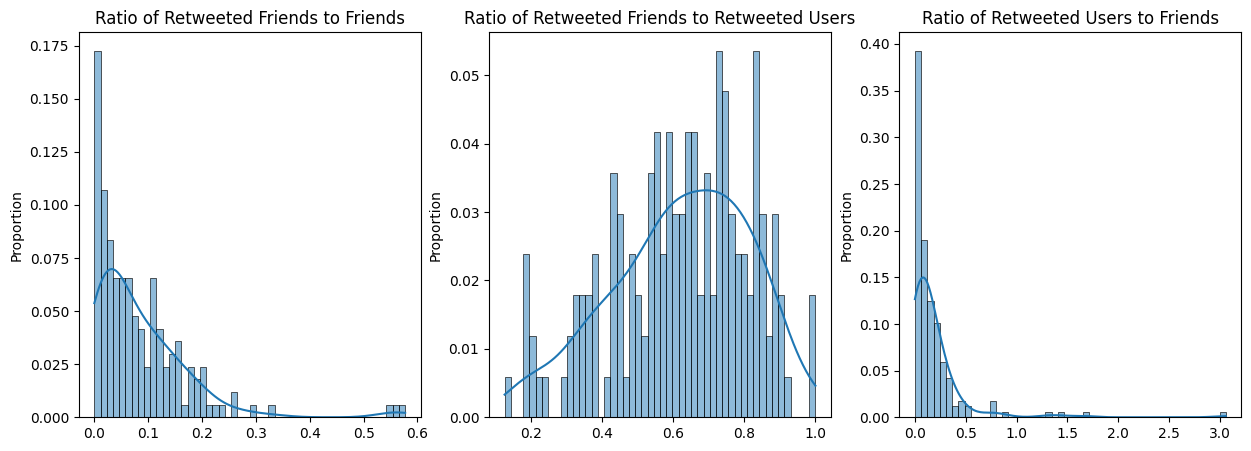

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot distributions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(data=rtff, ax=axs[0], kde=True, stat="proportion", bins=50)
# Title
axs[0].set_title("Ratio of Retweeted Friends to Friends")
sns.histplot(data=rtfrtu, ax=axs[1], kde=True, stat="proportion", bins=50)
axs[1].set_title("Ratio of Retweeted Friends to Retweeted Users")
sns.histplot(data=rtuf, ax=axs[2], kde=True, stat="proportion", bins=50)
axs[2].set_title("Ratio of Retweeted Users to Friends")
# Save
# plt.savefig("chessable_intersection_distributions.png")


In [ ]:
username = "chessable"

rtff, rtfrtu, rtuf = compare_retweeted_and_friends(username)
log.info(f"Retweeted friends ratio: {rtff}")
log.info(f"Retweeted friends to retweeted users ratio: {rtfrtu}")
log.info(f"Retweeted users to friends ratio: {rtuf}")
# hardmaru: friends - 0.2, retweets - 0.05
start_thresh = 0.3
end_thresh = 0.5
# Split into 5 thresholds
thresholds = np.linspace(start_thresh, end_thresh, 5)
log.info(f"Thresholds: {thresholds}")
avg_sims = []
for thresh in thresholds:
    log.info(f"Running with threshold: {thresh}")
    friends_map, sim_map = compare_user_friends(username, "friends", "user retweets", thresh)
    log.info(f"Similarity map: {str(sim_map)}")

    # Filter sim_map, keys with non-zero values
    filtered_sim_map = {k: v for k, v in sim_map.items() if v > 0}
    log.info(f"Similarity map - non-zero similarity: {str(filtered_sim_map)}")

    friend_count = len([k for k, v in friends_map.items() if len(v) > 0])

    log.info(f"Number of friends: {friend_count}")

    # Average similarity
    avg_sim = sum(sim_map.values()) / friend_count
    log.info(f"Average similarity for threshold={thresh} is: {avg_sim}")
    avg_sims.append(avg_sim)

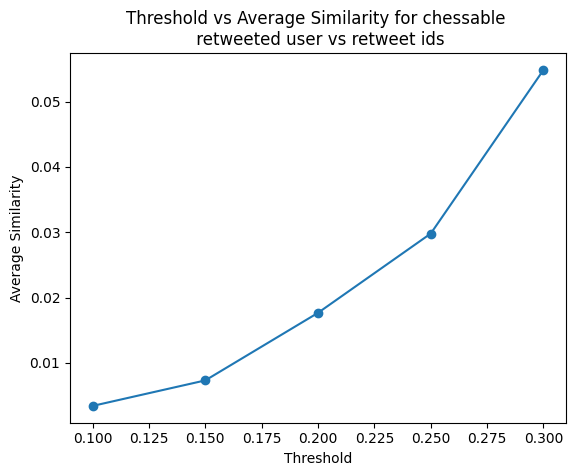

In [16]:
# Plot thresholds vs average similarity
import matplotlib.pyplot as plt
plt.plot(thresholds, avg_sims, marker='o')
plt.xlabel("Threshold")
plt.ylabel("Average Similarity")
plt.title(f"Threshold vs Average Similarity for {username} \n friends vs retweeted users")
plt.savefig(f"threshold_vs_avg_sim_{username}-higher.png")
plt.show()

### Ranking Experiments

Three things to investigate:
1. During the clustering loop, we typically choose the curr_user to be the highest ranked user. What happens if we instead choose the 2nd highest ranked user? 3rd highest? 4th highest? etc. Is the final cluster robust to this choice?
2. To what extent does the final clustering change depending on different intersection strategies: original, top k, average, etc.
3. To what extent does the ranking change depending on different intersection strategies: original, top k, average, etc.

In [3]:
"""From ranking_users_in_clusters.py"""

DEFAULT_PATH = str(get_project_root()) + "/src/scripts/config/create_social_graph_and_cluster_config.yaml"

def original_get_intersection_ranking(prod, con, infl1, infl2):
    """Produces a ranking that is the intersection of the Production,
    Consumption, Influence One, and Influence Two rankings

    Args:
        prod, con, infl1, infl2:
            Are dictionaries where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    # We use prod here as it's the same user list anyways
    prod_ranking = list(sorted(prod, key=lambda x: (prod[x][0], prod[x][1]), reverse=True))
    con_ranking = list(sorted(prod, key=lambda x: (con[x][0], con[x][1]), reverse=True))
    infl1_ranking = list(sorted(prod, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True))
    infl2_ranking = list(sorted(prod, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True))
    top_all = {}
    for i in range(1, len(prod_ranking) + 1):
        top_prod = set(prod_ranking[:i])
        top_con = set(con_ranking[:i])
        top_infl1 = set(infl1_ranking[:i])
        top_infl2 = set(infl2_ranking[:i])
        intersection = top_prod.intersection(
            top_con).intersection(
            top_infl1).intersection(
            top_infl2)

        for user in intersection:
            if user not in top_all:
                top_all[user] = [i, infl2_ranking.index(user)]

        #if len(intersection) >= 20: break
        if len(intersection) >= 10: break

    return sorted(top_all, key=lambda x: (top_all[x][0], top_all[x][1]))

In [9]:
def get_intersection_ranking_avg(prod, con, infl1, infl2):
    """Produces a ranking that is the intersection of the Production,
    Consumption, Influence One, and Influence Two rankings

    Args:
        prod, con, infl1, infl2:
            Are dictionaries where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    # We use prod here as it's the same user list anyways
    prod_ranking = list(sorted(prod, key=lambda x: (prod[x][0], prod[x][1]), reverse=True))
    con_ranking = list(sorted(prod, key=lambda x: (con[x][0], con[x][1]), reverse=True))
    infl1_ranking = list(sorted(prod, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True))
    infl2_ranking = list(sorted(prod, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True))
    top_all = {}
    
    for user in prod_ranking:
        # Get average rank
        avg_rank = (prod_ranking.index(user) + con_ranking.index(user) + infl1_ranking.index(user) + infl2_ranking.index(user)) / 4
        top_all[user] = [avg_rank, infl2_ranking.index(user)] # second value is just for tie breaking

    return sorted(top_all, key=lambda x: (top_all[x][0], top_all[x][1]))[:10]

In [14]:
def get_intersection_ranking_min(prod, con, infl1, infl2):
    """Produces a ranking that is the intersection of the Production,
    Consumption, Influence One, and Influence Two rankings

    Args:
        prod, con, infl1, infl2:
            Are dictionaries where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    # We use prod here as it's the same user list anyways
    prod_ranking = list(sorted(prod, key=lambda x: (prod[x][0], prod[x][1]), reverse=True))
    con_ranking = list(sorted(prod, key=lambda x: (con[x][0], con[x][1]), reverse=True))
    infl1_ranking = list(sorted(prod, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True))
    infl2_ranking = list(sorted(prod, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True))
    top_all = {}
    
    for user in prod_ranking:
        # Get min rank
        min_rank = min(prod_ranking.index(user), con_ranking.index(user), infl1_ranking.index(user), infl2_ranking.index(user))
        top_all[user] = [min_rank, infl2_ranking.index(user)] # second value is just for tie breaking

    return sorted(top_all, key=lambda x: (top_all[x][0], top_all[x][1]))[:10]

In [15]:
# Redundant. If you think about it, this always gives the same results as min.
def union_get_intersection_ranking(prod, con, infl1, infl2):
    """Produces a ranking that is the intersection of the Production,
    Consumption, Influence One, and Influence Two rankings

    Args:
        prod, con, infl1, infl2:
            Are dictionaries where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    # We use prod here as it's the same user list anyways
    prod_ranking = list(sorted(prod, key=lambda x: (prod[x][0], prod[x][1]), reverse=True))
    con_ranking = list(sorted(prod, key=lambda x: (con[x][0], con[x][1]), reverse=True))
    infl1_ranking = list(sorted(prod, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True))
    infl2_ranking = list(sorted(prod, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True))
    top_all = {}
    for i in range(1, len(prod_ranking) + 1):
        top_prod = set(prod_ranking[:i])
        top_con = set(con_ranking[:i])
        top_infl1 = set(infl1_ranking[:i])
        top_infl2 = set(infl2_ranking[:i])
        intersection = top_prod.union(
            top_con).union(
            top_infl1).union(
            top_infl2)

        for user in intersection:
            if user not in top_all:
                top_all[user] = [i, infl2_ranking.index(user)]

        #if len(intersection) >= 20: break
        if len(intersection) >= 10: break

    return sorted(top_all, key=lambda x: (top_all[x][0], top_all[x][1]))

In [35]:
def get_intersection_ranking_borda(prod, con, infl1, infl2):
    # We use prod here as it's the same user list anyways
    prod_ranking = list((sorted(prod, key=lambda x: (prod[x][0], prod[x][1]), reverse=True)))
    con_ranking = list((sorted(prod, key=lambda x: (con[x][0], con[x][1]), reverse=True)))
    infl1_ranking = list((sorted(prod, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True)))
    infl2_ranking = list((sorted(prod, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True)))
    top_all = {}
    for user in prod_ranking:
        prod_borda_score = 1 / (prod_ranking.index(user) + 1)
        con_borda_score = 1 / (con_ranking.index(user) + 1)
        infl1_borda_score = 1 / (infl1_ranking.index(user) + 1)
        infl2_borda_score = 1 / (infl2_ranking.index(user) + 1)
        top_all[user] = [prod_borda_score + con_borda_score + infl1_borda_score + infl2_borda_score, infl2_ranking.index(user)]
    return sorted(top_all, key=lambda x: (-top_all[x][0], top_all[x][1]))[:10]

In [36]:
def get_intersection_ranking_borda_linear(prod, con, infl1, infl2):
    # We use prod here as it's the same user list anyways
    prod_ranking = list((sorted(prod, key=lambda x: (prod[x][0], prod[x][1]), reverse=True)))
    con_ranking = list((sorted(prod, key=lambda x: (con[x][0], con[x][1]), reverse=True)))
    infl1_ranking = list((sorted(prod, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True)))
    infl2_ranking = list((sorted(prod, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True)))

    prod_linspace = np.linspace(1, 0, len(prod_ranking))
    con_linspace = np.linspace(1, 0, len(con_ranking))
    infl1_linspace = np.linspace(1, 0, len(infl1_ranking))
    infl2_linspace = np.linspace(1, 0, len(infl2_ranking))

    top_all = {}
    for user in prod_ranking:
        prod_borda_score = prod_linspace[prod_ranking.index(user)]
        con_borda_score = con_linspace[con_ranking.index(user)]
        infl1_borda_score = infl1_linspace[infl1_ranking.index(user)]
        infl2_borda_score = infl2_linspace[infl2_ranking.index(user)]
        top_all[user] = [prod_borda_score + con_borda_score + infl1_borda_score + infl2_borda_score, infl2_ranking.index(user)]

    return sorted(top_all, key=lambda x: (-top_all[x][0], top_all[x][1]))[:10]

In [11]:
def get_user_ranks(seed_user_name, cluster, path=DEFAULT_PATH):
    """Returns the top 10 ranked users from the given cluster with the seed id as user's id."""
    def get_user_id(user_name):
        user = user_getter.get_user_by_screen_name(user_name)
        user_id = str(user.id)
        return user_id
    user_id = get_user_id(seed_user_name)
    # apply to all users in cluster
    cluster.users = [get_user_id(user_name) for user_name in cluster.users]
    
    injector = sdi.Injector.get_injector_from_file(path)
    process_module = injector.get_process_module()

    prod_ranker = process_module.get_ranker()
    con_ranker = process_module.get_ranker("Consumption")
    infl1_ranker = process_module.get_ranker("InfluenceOne")
    infl2_ranker = process_module.get_ranker("InfluenceTwo")

    # Second argument is the return of score_users
    prod_rank, prod = prod_ranker.rank(user_id, cluster)
    con_rank, con = con_ranker.rank(user_id, cluster)
    infl1_rank, infl1 = infl1_ranker.rank(user_id, cluster)
    infl2_rank, infl2 = infl2_ranker.rank(user_id, cluster)

    return prod, con, infl1, infl2

In [40]:
test_cluster_users = ['hardmaru', 'AlphaSignalAI', 'DrJimFan', 'alexjc', 'peteskomoroch', 'tszzl', 'l2k', 'ykilcher', 'JayAlammar', 'bhutanisanyam1', 'mervenoyann', 'weights_biases', 'ClementDelangue', 'soumithchintala', 'bbriniotis', 'shaneguML', 'Thom_Wolf', 'DynamicWebPaige', 'pabbeel', '_akhaliq', 'suzatweet', 'alfcnz', 'ogrisel', 'jeffclune', 'seb_ruder', 'jeremyphoward', 'deliprao', 'ericjang11', 'karpathy']
seed_user = 'hardmaru' # important that this is in test_cluster_users
cluster = Cluster(seed_user, test_cluster_users)
prod, con, infl1, infl2 = get_user_ranks(seed_user, cluster)

def get_intersection_ranking(intersection_fn, prod, con, infl1, infl2):
    intersection_ranking = intersection_fn(prod, con, infl1, infl2)
    top_n_users = [user_getter.get_user_by_id(id).screen_name for id in intersection_ranking]
    return top_n_users

100%|██████████| 29/29 [00:00<00:00, 81.85it/s]


In [41]:
prod_ranking = list((sorted(prod, key=lambda x: (prod[x][0], prod[x][1]), reverse=True)))
prod_ranking_names = [user_getter.get_user_by_id(id).screen_name for id in prod_ranking]
con_ranking = list((sorted(prod, key=lambda x: (con[x][0], con[x][1]), reverse=True)))
con_ranking_names = [user_getter.get_user_by_id(id).screen_name for id in con_ranking]
infl1_ranking = list((sorted(prod, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True)))
infl1_ranking_names = [user_getter.get_user_by_id(id).screen_name for id in infl1_ranking]
infl2_ranking = list((sorted(prod, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True)))
infl2_ranking_names = [user_getter.get_user_by_id(id).screen_name for id in infl2_ranking]

print("Prod: ", prod_ranking_names)
print("Con: ", con_ranking_names)
print("Infl1: ", infl1_ranking_names)
print("Infl2: ", infl2_ranking_names)

Prod:  ['hardmaru', '_akhaliq', 'karpathy', 'DrJimFan', 'mervenoyann', 'ClementDelangue', 'jeremyphoward', 'tszzl', 'Thom_Wolf', 'weights_biases', 'JayAlammar', 'deliprao', 'AlphaSignalAI', 'ericjang11', 'shaneguML', 'soumithchintala', 'DynamicWebPaige', 'bhutanisanyam1', 'l2k', 'suzatweet', 'alexjc', 'ykilcher', 'alfcnz', 'seb_ruder', 'jeffclune', 'pabbeel', 'bbriniotis', 'peteskomoroch', 'ogrisel']
Con:  ['shaneguML', '_akhaliq', 'ClementDelangue', 'peteskomoroch', 'jeremyphoward', 'DynamicWebPaige', 'suzatweet', 'hardmaru', 'mervenoyann', 'l2k', 'AlphaSignalAI', 'deliprao', 'DrJimFan', 'Thom_Wolf', 'ericjang11', 'tszzl', 'bhutanisanyam1', 'alexjc', 'alfcnz', 'karpathy', 'jeffclune', 'pabbeel', 'weights_biases', 'ogrisel', 'JayAlammar', 'ykilcher', 'bbriniotis', 'soumithchintala', 'seb_ruder']
Infl1:  ['karpathy', 'Thom_Wolf', 'suzatweet', 'soumithchintala', 'ClementDelangue', 'shaneguML', 'pabbeel', 'hardmaru', 'l2k', 'DrJimFan', 'mervenoyann', 'AlphaSignalAI', 'jeremyphoward', 'wei

In [38]:
intersection_fn = get_intersection_ranking_avg
top_n_users = get_intersection_ranking(intersection_fn, prod, con, infl1, infl2)
log.info(f"Top 10 users: {top_n_users} using function {intersection_fn.__name__}")

2023-06-07 01:06:22 - __main__ - INFO - Top 10 users: ['hardmaru', 'ClementDelangue', 'fchollet', 'suzatweet', 'deliprao', 'jackclarkSF', 'tszzl', 'balajis', 'peteskomoroch', 'Miles_Brundage'] using function get_intersection_ranking_avg


In [42]:
intersection_fns = [original_get_intersection_ranking, get_intersection_ranking_avg, get_intersection_ranking_min, get_intersection_ranking_borda]
# Check pairwise intersection
for i, intersection_fn in enumerate(intersection_fns):
    top_n_users = get_intersection_ranking(intersection_fn, prod, con, infl1, infl2)
    for intersection_fn2 in intersection_fns[i+1:]:
        if intersection_fn2 == intersection_fn:
            continue
        top_n_users2 = get_intersection_ranking(intersection_fn2, prod, con, infl1, infl2)
        changes = {user: top_n_users.index(user) - top_n_users2.index(user) if user in top_n_users2 else "removed" for user in top_n_users}
        intersection = set(top_n_users).intersection(set(top_n_users2))
        log.info(f"Changes between {intersection_fn.__name__} and {intersection_fn2.__name__}: {changes}")
        # log.info(f"Top 10 user intersection between {intersection_fn.__name__} and {intersection_fn2.__name__}: {intersection}")
        log.info(f"Total intersection: {len(intersection)}")

2023-06-07 01:10:20 - __main__ - INFO - Changes between original_get_intersection_ranking and get_intersection_ranking_avg: {'ClementDelangue': 0, 'hardmaru': 0, 'jeremyphoward': -1, 'DrJimFan': -4, 'Thom_Wolf': -2, 'shaneguML': 1, 'ericjang11': 'removed', '_akhaliq': 5, 'AlphaSignalAI': 'removed', 'mervenoyann': 0}
2023-06-07 01:10:20 - __main__ - INFO - Total intersection: 8
2023-06-07 01:10:20 - __main__ - INFO - Changes between original_get_intersection_ranking and get_intersection_ranking_min: {'ClementDelangue': 0, 'hardmaru': 0, 'jeremyphoward': -2, 'DrJimFan': -5, 'Thom_Wolf': -2, 'shaneguML': 3, 'ericjang11': 'removed', '_akhaliq': 2, 'AlphaSignalAI': 'removed', 'mervenoyann': 'removed'}
2023-06-07 01:10:20 - __main__ - INFO - Total intersection: 7
2023-06-07 01:10:20 - __main__ - INFO - Changes between original_get_intersection_ranking and get_intersection_ranking_borda: {'ClementDelangue': 0, 'hardmaru': 0, 'jeremyphoward': -3, 'DrJimFan': -5, 'Thom_Wolf': -2, 'shaneguML': 2

Out of 10 users, intersections are typically at least 5 between all intersection functions.